In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# plt.rcParams['font.family'] = 'monospace'
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import pickle
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

C2 = 1.006

__________________
## Dump data for $B\rightarrow K^*$ and $B\rightarrow K$

__NOTE:__ Do not run this unless you have the data. You can load data below.

In [2]:
# set dump to True to dump data
dump = True

if dump:
    # specify path to the data below
    # FDD_path = '../../../bsll-2021/Normal-Runs/Global-SM-1/SM/FDD/SM/gtilde.txt'
    # PDD_path = '../../../bsll-2021/Normal-Runs/Global-SM-1/SM/PDD/SM/gtilde.txt'
    # PMD_path = '../../../bsll-2021/Normal-Runs/Global-SM-1/SM/PMD/SM/gtilde.txt'
    # FDD_BK_path = '../../../bsll-2021/Normal-Runs/Global-SM-1/SM/FDD/SM/DC9_BK.txt'
    
    FDD_path = '../../../TheNewHope/PSR3/SM/FDD/SM/gtilde.txt'
    PDD_path = '../../../TheNewHope/PSR3/SM/PDD/SM/gtilde.txt'
    PMD_path = '../../../TheNewHope/PSR3/SM/PMD/SM/gtilde.txt'
    FDD_BK_path = '../../../TheNewHope/PSR3/SM/FDD/SM/DC9_BK.txt'
    noKD_path = '../../../bsll-2021/Old-LHCb-1/SM/FDD/SM/gtilde.txt'
    
    C9 = [4.851167613, 4.833210117, 4.837980395, 4.849896316, 4.865860999, 4.885166647, 4.90780998,4.934192529, 4.965121081, 
          5.001994359, 5.04730717, 5.106069325, 5.19124535, 5.382206997, 5.431870677, 5.372699572, 5.319896073]
    
    df_C9 = pd.DataFrame(C9, columns={'C9'})
    
    x = ([0.1]+list(np.linspace(0.5, 8, 16)))*3

    # data for gtilde FDD
    gtilde_FDD = pd.read_csv(FDD_path, header=None)
    gtilde_FDD.columns = ['mean', 'sd']
    gtilde_FDD['upper'] = gtilde_FDD['mean'] + gtilde_FDD['sd']
    gtilde_FDD['lower'] = gtilde_FDD['mean'] - gtilde_FDD['sd']
    gtilde_FDD['q2'] = x

    # data for gtilde PDD
    gtilde_PDD = pd.read_csv(PDD_path, header=None)
    gtilde_PDD.columns = ['mean', 'sd']
    gtilde_PDD['upper'] = gtilde_PDD['mean'] + gtilde_PDD['sd']
    gtilde_PDD['lower'] = gtilde_PDD['mean'] - gtilde_PDD['sd']
    gtilde_PDD['q2'] = x

    # data for gtilde PMD
    gtilde_PMD = pd.read_csv(PMD_path, header=None)
    gtilde_PMD.columns = ['mean', 'sd']
    gtilde_PMD['upper'] = gtilde_PMD['mean'] + gtilde_PMD['sd']
    gtilde_PMD['lower'] = gtilde_PMD['mean'] - gtilde_PMD['sd']
    gtilde_PMD['q2'] = x
    
    # data for gtilde from old LHCb data
    gtilde_noKD = pd.read_csv(noKD_path, header=None)
    gtilde_noKD.columns = ['mean', 'sd']
    gtilde_noKD['upper'] = gtilde_noKD['mean'] + gtilde_noKD['sd']
    gtilde_noKD['lower'] = gtilde_noKD['mean'] - gtilde_noKD['sd']
    gtilde_noKD['q2'] = x
    
    # QCDF
    df_QCDF = pd.read_csv('../../data/bsll_2021/QCDF.txt', sep ='\t', header=None)
    df_QCDF.columns = ['mean', 'sd']
    # Adjust QCDF here since it is later multiplied by 2*C2
    df_QCDF['mean'] = df_QCDF['mean']/2/C2
    df_QCDF['sd'] = df_QCDF['sd']/2/C2
    df_QCDF['upper'] = df_QCDF['mean'] + df_QCDF['sd']
    df_QCDF['lower'] = df_QCDF['mean'] - df_QCDF['sd']
    df_QCDF['q2'] = x
    
    # B to K
    df_BK_FDD = pd.read_csv(FDD_BK_path, header=None)
    df_BK_FDD.columns = ['mean', 'sd']
    # Adjust QCDF here since it is later multiplied by 2*C2
    df_BK_FDD['mean'] = df_BK_FDD['mean']/2/C2
    df_BK_FDD['sd'] = df_BK_FDD['sd']/2/C2
    df_BK_FDD['upper'] = df_BK_FDD['mean'] + df_BK_FDD['sd']
    df_BK_FDD['lower'] = df_BK_FDD['mean'] - df_BK_FDD['sd']
    df_BK_FDD['q2'] = np.linspace(1, 8.01, 15)

    data = {}
    data['FDD'] = gtilde_FDD
    data['PDD'] = gtilde_PDD
    data['PMD'] = gtilde_PMD
    data['noKD'] = gtilde_noKD
    data['QCDF'] = df_QCDF
    data['C9'] = df_C9
    data['BtoK_FDD'] = df_BK_FDD

    with open('../../data/bsll_2021/gtilde_SM.data', 'wb') as f:
        pickle.dump(data, f)

______________
## Load Data 

In [3]:
with open('../../data/bsll_2021/gtilde_SM.data', 'rb') as f:
    data = pickle.load(f)

________________
## Function for making the plots

In [4]:
# def makegTilde(com, filename, colors=['#710200', '#006f71', '#e67e00', '#B392AC', '#41393e', '#1c7293']):
order = ['QCDF', 'PMD', 'noKD', 'PDD', 'FDD']
colors = ['#41393e', 'limegreen', '#B392AC', 'crimson', 'orange']
def makegTilde(com, filename, colors=colors+['#1c7293']):
    ''' Function to plot gtilde
        argument:
            com: an integer to specify the compment of gtilde. Can be 1, 2 or 3
        return:
            plt: the matplotlib pyplot object
    '''

    # set figure size
    plt.figure(figsize=(6,4))
    
    # lower and upper index for the different helicity components
    lb = (com - 1) * 17 + 1
    ub = 17 * com
    
    # Plot C9 SD
    plt.plot(np.linspace(0, 8.01, 17), data['C9'].iloc[0:], color=colors[5])

    # Plot for FDD, PDD, PMD and QCDF
    for i, key in enumerate(order):
        splineplot(key, color=colors[i], lb=lb, ub=ub)
        
    # settings for the plot
    plt.xlim(1,8)
    plt.ylim(0,7)
    plt.grid(':', alpha=0.4)
    plt.xlabel(r'$q^2\ [\rm{GeV}^2]$', fontsize=16)
    # plt.ylabel(r'$|2C_2\tilde g_'+str(com)+'|\sim \Delta C_9$', fontsize=16)
    plt.ylabel(r'$|\Delta C_{9,'+str(com)+'}(q^2)|$', fontsize=16)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # add the logo
    # placeLogo(2.075, 2.8)
    
    # make the legend
    size = 12
    line0 = Line2D([0], [0], color=colors[4], linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.3)
    line1 = Line2D([0], [0], color=colors[2], linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.3)
    line2 = Line2D([0], [0], color=colors[1], linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.3)
    line3 = Line2D([0], [0], color=colors[3], linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.3)
    line4 = Line2D([0], [0], color=colors[0], linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.3)
    line5 = Line2D([0], [0], color=colors[5], linewidth=2, linestyle='-', solid_capstyle='butt', alpha=0.8)
    # labels = ['FDD', 'PDD', 'PMD', 'noKD', r'$C_9^{QCDF}$', r'$C_9^{SD}$']
    labels = [r'$\rm{Data\ Driven\ (current)}$', r'$\rm{Data\ Driven\ (2015)}$', r'$\rm{LCSR}$', r'$\rm{LCSR}\ @\ q^2 \le 1$', r'$C_9^{\rm QCDF}$', r'$C_9^{\rm SD}$']
    leg = plt.figlegend(handles=[line0, line1, line2, line3, line4, line5], labels=labels, handlelength=2.1, labelspacing=0.15, bbox_to_anchor=[0.97, 0.95],
                    loc='upper right', prop={'size': size}, ncol=3, fancybox=True, framealpha=1, columnspacing=0.9)
    
    # output
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
    return plt


def splineplot(key, color, lb, ub):
    # read data
    x = data[key].q2.iloc[lb:ub]
    y = 2 * C2 * data[key]['mean'].iloc[lb:ub]
    xplot = np.linspace(0.005, 8, 100)

    # spline for the mean
    spline = interpolate.splrep(x, y, s=0)
    yplot = interpolate.splev(xplot, spline, der=0)

    # spline for the upper bound
    y = 2 * C2 * data[key]['upper'].iloc[lb:ub]
    spline = interpolate.splrep(x, y, s=0)
    yplot_u = interpolate.splev(xplot, spline, der=0)

    # spline for the lower bound
    y = 2 * C2 * data[key]['lower'].iloc[lb:ub]
    spline = interpolate.splrep(x, y, s=0)
    yplot_l = interpolate.splev(xplot, spline, der=0)

    # make the plots
    plt.plot(xplot, yplot, label=str(key), color=color)
    plt.fill_between(xplot, yplot_u, yplot_l, alpha=0.3, color=color)
    
    
def placeLogo(bottom, left):
    # add the logo
    plt3 = plt.twinx()
    plt3.axis('off')
    plt3.set_ylim(bottom=0, top=1)
    logo = mpimg.imread('../../plots/logo/HEPfit-logo.png')
    size = 0.5
    bottom = bottom
    top = bottom + size
    left = left
    right = left + size*2.3398
    extent = (left, right, bottom, top)
    imgplot = plt.imshow(logo, extent=extent, alpha=0.85)

______________________
## $B\rightarrow K^*$ plots

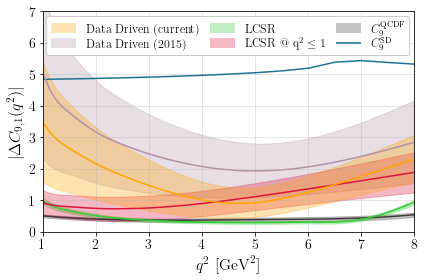

In [5]:
plt_1 = makegTilde(1, '../../plots/bsll_2021/gtilde_1.pdf')

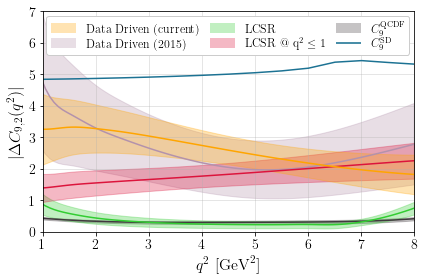

In [6]:
plt_2 = makegTilde(2, '../../plots/bsll_2021/gtilde_2.pdf')

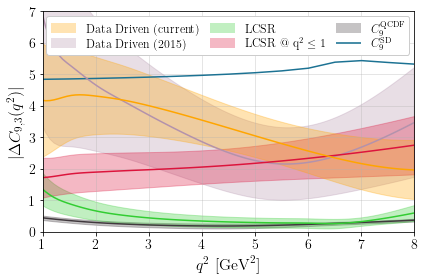

In [7]:
plt_3 = makegTilde(3, '../../plots/bsll_2021/gtilde_3.pdf')

_______________
## $B\rightarrow K$ plots

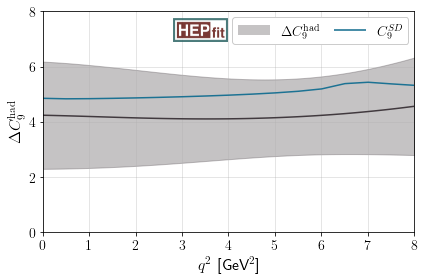

In [8]:
# set figure size
plt.figure(figsize=(6,4))

# plot C9 SD
plt.plot(np.linspace(0, 8.01, 17), data['C9'].iloc[0:], color='#1c7293')

# plot hadronic DC9
splineplot('BtoK_FDD', '#41393e', 0, -1)
plt.grid(':', alpha=0.3)

# settings for the plot
plt.xlim(0,8)
plt.ylim(0,8)
plt.grid(':', alpha=0.4)
plt.xlabel(r'$q^2$ [GeV$^2$]', fontsize=16)
plt.ylabel(r'$\Delta C_9^{\rm had}$', fontsize=16)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)

# add the logo
placeLogo(2.215, 2.8)

# add the legend
size = 14
line0 = Line2D([0], [0], color='#41393e', linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.3)
line1 = Line2D([0], [0], color='#1c7293', linewidth=2, linestyle='-', solid_capstyle='butt', alpha=0.8)
labels = [r'$\Delta C_9^{\rm had}$', r'$C_9^{SD}$',]
leg = plt.figlegend(handles=[line0, line1], labels=labels, handlelength=2.3, labelspacing=0.15, bbox_to_anchor=[0.97, 0.95],
                loc='upper right', prop={'size': size}, ncol=2, fancybox=True, framealpha=1, columnspacing=1)

# output
plt.tight_layout()
plt.savefig('../../plots/bsll_2021/BtoK_FDD.pdf', dpi=300)
plt.show()